# Understanding the Factors Influencing English Premier League Match Outcomes

keywords: Premier League, match outcomes, Exploratory Data Analysis, COVID-19, football.

## Introduction

Football, particularly the English Premier League (EPL), captivates millions of fans globally. Established in 1992, the EPL is renowned not only for its intense competition but also for its widespread popularity, both domestically and internationally. This appeal extends beyond the fans to include significant interest from the sports betting industry, where predictive models can offer valuable insights for bettors.

Technological advancements have revolutionized the game's play and analysis over the years. Innovations like the Video Assistant Referee (VAR), computer vision, wearable technology, and robotics have enhanced both the viewing experience and the strategic aspects of football (Myerson Solicitors, 2023). These advancements have also facilitated extensive data collection, which is vital for sports analytics.

This research aims to conduct a comprehensive examination of the factors influencing match outcomes in the English Premier League (EPL). While the analysis may provide insights with potential applications in betting, the primary focus is to understand the dynamics of match results through data analytics. By performing an exploratory data analysis (EDA) on a dataset containing Premier League football data, the goal is to uncover the variables, patterns, and trends that impact match outcomes. This analysis entails acquiring and preparing the dataset, conducting data cleaning and preprocessing, performing descriptive statistics and visualizations, and identifying key insights and challenges in the data. Additionally, the Python code used for these operations, along with some explanations, is provided for reproducibility.

The dataset utilized for this analysis was sourced from football-data.co.uk (football-data.co.uk, 2024), encompassing a variety of match statistics and betting odds. Through this EDA, the aim is to underscore the importance of data-driven approaches in football analytics and their potential applications in understanding match outcomes better.

## Data Collection

Data acquisition is a fundamental step before undertaking pre-processing and visualization. For this project, the data collected about the English Premier League is used in the betting industry for testing betting systems. The dataset was acquired from football-data.co.uk, a free football betting portal providing historical results and odds. This resource helps football betting enthusiasts analyze many years of data quickly and efficiently, leveraging quantitative analysis to gain an edge over the bookmaker.

### Data Acquisition Technique
The chosen data acquisition method—scraping data—was justified based on the dataset's format and availability. The data was readily available in CSV format on the website, making web scraping an efficient and automatic method for obtaining the required data. The use of a structured format (CSV) facilitated easy integration with the `pandas` library (The pandas development team, 2020) for further pre-processing and data manipulation.

### The Scraper

The scraper used to collect the data from football-data.co.uk utilized the following Python libraries:

* `Beautiful Soup` (Richardson, 2007): Utilized for parsing HTML and scraping the data from the website.
* `HTMLSession from requests_html`: Employed for managing sessions and making HTTP requests to fetch web pages.
* `logging`: Used for tracking events occurring during the execution of the scraping script.
* `urljoin from urllib.parse`: Utilized for constructing absolute URLs from relative URLs on the website.

In [5]:
# Importing necessary libraries for data processing and data manipulation
import pandas as pd
import numpy as np

# import libraries for scraping and downloading datasets directly from football-data.co.uk
from bs4 import  BeautifulSoup
from requests_html import HTMLSession
import logging
from urllib.parse import urljoin

# import libraries to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Configure logging to capture errors
logging.basicConfig(level=logging.ERROR)

def get_html_content(url):
    """
    Fetch HTML content from the given URL.

    Args:
    url (str): The URL to fetch HTML content from.

    Returns:
    bytes or None: The HTML content if successful, None otherwise.
    """
    try:
        session = HTMLSession()  # Create a session to fetch content
        response = session.get(url)  # Perform a GET request
        response.raise_for_status()  # Raise HTTPError for bad status codes
        return response.content  # Return the HTML content
    except Exception as e:
        logging.error("Error fetching URL: %s", e)  # Log any errors that occur
        return None  # Return None if there's an error

def extract_football_csv_urls(main_url, league_folder, start_season, end_season, league_id):
    """
    Extract CSV URLs from HTML content based on specific criteria.

    Args:
    main_url (str): The main URL containing HTML content.
    league_folder (str): The folder name indicating the league.
    start_season (int): The starting season year.
    end_season (int): The ending season year.
    league_id (str): The ID indicating the league.

    Returns:
    list: A list of CSV URLs.
    """
    html_content = get_html_content(main_url)  # Fetch HTML content

    if html_content is None:
        logging.error("Error fetching HTML content from URL: %s", main_url)  # Log error if content is None
        return []  # Return empty list if there's an error

    soup = BeautifulSoup(html_content, 'html.parser')  # Parse HTML content with BeautifulSoup
    csv_urls = []
    for link in soup.find_all('a', href=True):  # Find all anchor tags with href attribute
        href = link['href']
        if league_folder in href and league_id in href:  # Check if href contains league_folder and league_id
            parts = href.split('/')
            if len(parts) == 3:  # Check if the href follows the expected format
                season_str = parts[1]
                # Handling different season formats
                if season_str == '9900':
                    season_start = 1999
                    season_end = 2000
                elif season_str.startswith('9'):
                    season_start = int(season_str[:2]) + 1900
                    season_end = int(season_str[2:]) + 1900
                else:
                    season_start = int(season_str[:2]) + 2000
                    season_end = int(season_str[2:]) + 2000
                # Check if the season falls within the specified range
                if start_season <= season_end and end_season >= season_start:
                    csv_urls.append(urljoin(main_url, href))  # Add the full URL to the list
    return csv_urls  # Return the list of CSV URLs

def get_csv_content(url):
    """
    Fetch CSV content from the given URL.

    Args:
    url (str): The URL to fetch CSV content from.

    Returns:
    DataFrame or None: The CSV content as a DataFrame if successful, None otherwise.
    """
    try:
        return pd.read_csv(url, encoding='utf-8')  # Read CSV content into a DataFrame
    except Exception as e:
        logging.error("Error fetching CSV from URL %s: %s", url, e)  # Log any errors that occur
        return None  # Return None if there's an error

def get_football_data(main_url=None, league_folder=None, start_season=None, end_season=None, league_id=None):
    """
    Fetch football data from CSV URLs based on specific criteria.

    Args:
    main_url (str): The main URL containing HTML content.
    league_folder (str): The folder name indicating the league.
    start_season (int): The starting season year.
    end_season (int): The ending season year.
    league_id (str): The ID indicating the league.

    Returns:
    DataFrame or None: The combined football data as a DataFrame if successful, None otherwise.
    """
    # Extract CSV URLs based on criteria
    csv_urls = extract_football_csv_urls(main_url, league_folder, start_season, end_season, league_id)
    if csv_urls:
        dfs = []
        # Iterate over each CSV URL and fetch data
        for url in csv_urls:
            csv_content = get_csv_content(url)  # Fetch CSV content
            if csv_content is not None:
                dfs.append(csv_content)  # Append the DataFrame to the list
        # Concatenate data from all CSV files into a single DataFrame
        if dfs:
            combined_df = pd.concat(dfs, ignore_index=True)  # Combine all DataFrames
            return combined_df  # Return the combined DataFrame
        else:
            logging.error("No CSV content fetched.")  # Log error if no CSV content was fetched
    else:
        logging.error("No CSV URLs found.")  # Log error if no CSV URLs were found
    return None  # Return None if there's an error

### The dataset

The dataset utilized in this analysis is sourced from football-data.co.uk (football-data.co.uk, 2024), a publicly accessible platform offering football-related data. It comprises 1,900 observations and 105 features encompassing match statistics and betting odds spanning four seasons, ranging from 2019-2020 to 2023-2024. 

While additional seasons are available, the deliberate selection of the latest four seasons ensures data consistency, minimizes pre-processing efforts, and addresses resource constraints. However, this reduction limits the historical depth of the exploratory data analysis (EDA), potentially affecting the breadth of insights generated.

The dataset encompasses a diverse array of features, including:

* Match Results and Statistics: Encompassing information on goals, results, and various match statistics such as shots, fouls, corners, and cards.
* Betting Odds: Incorporating odds from multiple bookmakers across different bet types, such as match outcomes, total goals, and Asian handicaps.
* Closing Odds: Reflecting the final available odds before a match commences, offering insights into market dynamics.

However, it is important to acknowledge that the dataset has certain limitations, which will be further highlighted in the analysis and discussion section.

Existing literature has identified numerous factors influencing match outcomes, such as team formation (Buchheit, 2023a), rest days between matches (Buchheit, 2022; Verheijen, 2012), and match location (González-Rodenas, 2019; Lago-Peñas, 2016; Pollard, 1986), but these variables are not captured in the current dataset. Additionally, factors like team ranking (González-Rodenas, 2019), manager changes (Radzimiński, 2022), player availability (Hägglund, 2013; Eliakim, 2020), and player management strategies such as substitutions (Buchheit, 2023c) and rotations (Settembre, 2023; Bekris, 2020; Schmidt, 2017) have also been shown to play significant roles in match outcomes but are absent from the dataset used.

Given the temporal scope of the dataset, there arises an opportunity to investigate the potential impacts of external factors, such as the COVID-19 pandemic, on match outcomes during the analyzed seasons.

It is imperative to note that the dataset does not contain any sensitive or personal data, ensuring compliance with ethical standards and data protection regulations.

For a comprehensive list of features and their descriptions, please refer to the detailed dataset information provided in the accompanying text file.

In [8]:
# This script contains functions related to web scraping and data retrieval from football-data.co.uk.
# Parameters are set to reproduce the analysis of this report.
# Define the folder name indicating the league.
league_folder = "mmz4281"

# Define the starting season year.
start_season = 2020

# Define the ending season year.
end_season = 2024

# Define the ID indicating the league.
league_id = "E0"

# Define the main URL containing HTML content.
main_url = 'https://www.football-data.co.uk/englandm.php'

# Fetch football data based on specific criteria.
premier_league_df = get_football_data(main_url, league_folder, start_season, end_season, league_id)

In [9]:
# If you want to load the attached EPL dataset for this manuscript,
# uncomment the line below and run the script.
#premier_league_df = pd.read_csv("./premier-league.csv")

## Data Pre-Processing

Upon retrieving the data, it underwent essential pre-processing to ensure consistency, integrity and suitability for further analysis. The following steps were employed:

* Dropping irrelevant features and "Unnamed" columns.
* Handling missing values.
* Converting data types.
* Engineering features.
* Partitioning the dataset.

While unsupervised machine learning techniques like Principal Component Analysis (PCA) could potentially reduce dataset dimensionality and generate new features, due to the complexity of the Premier League dataset and to maintain comprehensive exploration, all dimensions were retained. For data pre-processing, the `pandas` and `numpy` (Harris et al., 2020) Python libraries were utilized.

### Drop irrelevant features and "Unnamed" columns

To streamline the dataset, irrelevant features and "Unnamed" columns were removed. This process was executed using the `filter()` function with REGEX to identify and drop empty columns. Additionally, the "Div" column, deemed irrelevant as all data pertains to the Premier League, was dropped using the `drop()` function.

This step ensured a more focused and concise dataset for subsequent analysis.

In [12]:
# Drop columns with "Unnamed" in their column names using regex
premier_league_df = premier_league_df.filter(regex=r'^(?!Unnamed).*$')

# Drop the "Div" column
premier_league_df = premier_league_df.drop('Div', axis=1)

### Handling missing values

Among the 105 features in the dataset, 22 contain missing values, all of which are associated with betting data. While the percentage of rows containing missing values, up to 9.74%, is relatively low, dropping these rows could result in a loss of valuable match instances for analysis. Therefore, to maximize the available data and ensure a comprehensive analysis, the decision was made to handle missing values through imputation.

Given that betting odds data typically fall into discrete categories representing specific intervals or values, imputing missing values with the mode, i.e., the most frequent value in each column, was deemed appropriate. This approach ensures that the imputed values align closely with the underlying distribution of betting odds data.

By retaining these rows and employing mode imputation, the dataset maintains its representativeness while minimizing data loss, thus facilitating a more robust analysis of match outcomes and betting trends.

In [14]:
# Get the sum of missing values per feature
missing_values_per_feature = premier_league_df.isna().sum()

# Filter features with missing values
missing_values_filtered = missing_values_per_feature[missing_values_per_feature > 0]

# Get the number of features with missing values
no_feat_w_missing_values = len(missing_values_filtered)

# Get the number of total rows in the dataframe
total_rows = len(premier_league_df)

# Calculate percentage of missing values
percentage_missing = round((missing_values_filtered / total_rows)*100,2)

# Print results for inspection
# Uncomment the print statements below
#print("* Number of features with missing values:", no_feat_w_missing_values)
#print("* Percentage of missing values per feature:\n\n", percentage_missing)

In [15]:
# Get features with NaN values
feat_with_nan = missing_values_filtered.index.tolist()

# Impute missing values with the mode by using apply and lambda function
# Lambda function is used to apply a specific operation to each column independently
# In this case, it fills NaN values in each column with the mode of that column
premier_league_df[feat_with_nan] = premier_league_df[feat_with_nan].apply(lambda x: x.fillna(x.mode()[0]))

### Convert data types

Before proceeding with the Exploratory Data Analysis (EDA), ensuring that features have the correct data type is essential for accurate analysis and visualization. To achieve this, the data types of specific features were converted using `astype()` and `pd.to_datetime()` functions.

In [17]:
# Convert "FTR" column to categorical data type
# This is useful for columns with a fixed number of unique values,
# such as "H" (Home win), "A" (Away win), and "D" (Draw).
premier_league_df['FTR'] = premier_league_df['FTR'].astype("category")

# Convert "Date" column to datetime data type
# This allows for easier manipulation and analysis of date-related data.
# The specified format ensures proper parsing of dates in the "Date" column.
premier_league_df['Date'] = pd.to_datetime(premier_league_df['Date'], format='%d/%m/%Y')

### Feature Engineering

In preparation for the Exploratory Data Analysis (EDA), feature engineering was conducted to enhance the dataset's informativeness and facilitate deeper insights into match outcomes. Two new features were introduced:

* `FTHGDIFF` (Full Time Home Goal Difference): This feature captures the difference between the number of goals scored by the home team (`FTHG`) and the number of goals scored by the away team (`FTAG`). It provides valuable context regarding the performance disparity between the home and away teams in each match, which is essential for understanding match dynamics and outcomes.
* `Season`: A new feature representing the football season was introduced to more accurately capture the temporal aspect of the data. This feature aligns with the traditional structure of football seasons, which typically span from one year to the next (e.g., 2023-2024 season). By aggregating data based on football seasons, the analysis process becomes more precise, allowing for a clearer examination of trends and patterns. This approach facilitates a better understanding of the evolution of key metrics and performance indicators over multiple football seasons.

In [19]:
# Create a new feature for Full Time Home Goal Difference
# This calculates the difference between full-time home goals (FTHG) and full-time away goals (FTAG),
# indicating the goal difference for each match where the home team played.
premier_league_df['FTHGDIFF'] = premier_league_df['FTHG'] - premier_league_df['FTAG']

# Create a Season column using a lambda function
# This lambda function dynamically assigns a season label based on the match date.
# If the match month is August or later, it assigns the season as "year-year+1",
# otherwise, it assigns the season as "year-1-year".
premier_league_df['Season'] = premier_league_df['Date'].apply(
    lambda date: f"{date.year}-{date.year + 1}" if date.month >= 8 else f"{date.year - 1}-{date.year}"
)

### Partitioning the dataset

Given the high dimensionality of the dataset, I partitioned the `premier_league_df` dataframe into subsets to facilitate the subsequent EDA more effectively. Each sub dataframe is categorized into main sections. Further details about features can be found in the attached file. Some features have been excluded as they are not relevant to the research question.

In [21]:
# Match Information
# Extracting essential match information.
# Columns: Date, Season, Time, HomeTeam, AwayTeam, Referee
match_info_cols = ['Date', 'Season', 'Time', 'HomeTeam', 'AwayTeam', 'Referee']
match_info_df = premier_league_df[match_info_cols]

# Match Results
# Extracting match outcome-related information.
# Excluded: 'HTHG' and 'HTAG' as they are not relevant to the research question.
# Columns: HTR (Half Time Result), FTHG (Full Time Home Goals), FTAG (Full Time Away Goals),
#          FTR (Full Time Result), FTHGDIFF (Full Time Home Goal Difference)
match_results_cols = ['HTR', 'FTHG', 'FTAG', 'FTR', 'FTHGDIFF']
match_results_df = premier_league_df[match_results_cols]

# Match Statistics
# Extracting match statistics.
# Columns: HS (Home Team Shots), AS (Away Team Shots), HST (Home Team Shots on Target),
#          AST (Away Team Shots on Target), HF (Home Team Fouls), AF (Away Team Fouls),
#          HC (Home Team Corners), AC (Away Team Corners), HY (Home Team Yellow Cards),
#          AY (Away Team Yellow Cards), HR (Home Team Red Cards), AR (Away Team Red Cards)
match_stats_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
match_stats_df = premier_league_df[match_stats_cols]

# Betting Odds
# Extracting betting odds.
# Excluded: Total Goals Betting Odds, Asian Handicap Betting Odds, Closing Odds
# Columns: B365H (Bet365 Home Win Odds), B365D (Bet365 Draw Odds), B365A (Bet365 Away Win Odds),
#          BWH (Bet&Win Home Win Odds), BWD (Bet&Win Draw Odds), BWA (Bet&Win Away Win Odds),
#          IWH (Interwetten Home Win Odds), IWD (Interwetten Draw Odds), IWA (Interwetten Away Win Odds),
#          PSH (Pinnacle Sports Home Win Odds), PSD (Pinnacle Sports Draw Odds), PSA (Pinnacle Sports Away Win Odds),
#          WHH (William Hill Home Win Odds), WHD (William Hill Draw Odds), WHA (William Hill Away Win Odds),
#          VCH (VC Bet Home Win Odds), VCD (VC Bet DraOdds), VCA (VC Bet Away Win Odds),
#          MaxH (Maximum Home Win Odds), MaxD (Maximum Draw Odds), MaxA (Maximum Away Win Odds),
#          AvgH (Average Home Win Odds), AvgD (Average Draw Odds), AvgA (Average Away Win Odds)
betting_odds_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 
                     'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 
                     'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 
                     'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']
betting_odds_df = premier_league_df[betting_odds_cols]

# Total Goals Betting Odds, Asian Handicap Betting Odds, and Closing Odds are not used for this research as they are out of scope.

## Analysis and discussion

After completing the data pre-processing, I proceeded with the analysis. In the following EDA, I aimed to address the research question concerning the features, patterns, and trends influencing match outcomes (`FTR`). For this step, I utilized the partitioned datasets and the `pandas` and `numpy` libraries for data manipulation, along with `matplotlib` (Hunter, 2007) and `seaborn` (Waskom, 2021) for data visualization.

The findings, facilitated by the partitioned datasets, are presented alongside the plots, offering insights into the relationships between various features and match outcomes, as well as identifying any notable patterns or trends. Subsequently, the implications of these findings are discussed in the context of the research question.

The analysis and discussions are structured into the following main categories:

* Match Results.
* Match Statistics.
* Betting Odds.

This organization provides a structured framework for comprehending the insights derived from the data.

In [23]:
#import libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# set matplotlib backend to inline
%matplotlib inline

### Match Results

In this section, to gather more insights about match outcomes, I examined the distribution of goals (`FTR`) independently for two different groups (home goals and away goals) in the `match_results_df`. For this univariate analysis, I used box plots to illustrate the distribution of home goals and away goals, and histograms to depict the frequency distribution of home goals and away goals.

In [25]:
# Calculate percentages for Half Time Result (HTR) and Full Time Result (FTR)
htr_counts = match_results_df['HTR'].value_counts(normalize=True) * 100
ftr_counts = match_results_df['FTR'].value_counts(normalize=True) * 100

# Combine into a single dataframe for plotting
percentage_df = pd.DataFrame({
    'HTR': htr_counts,
    'FTR': ftr_counts
}).reset_index().rename(columns={'index': 'Result'})

# Melt the dataframe for seaborn visualization
percentage_df_melted = percentage_df.melt(id_vars='Result', value_vars=['HTR', 'FTR'], var_name='Type', value_name='Percentage')


# Goal statistics
home_goals = match_results_df['FTHG']
away_goals = match_results_df['FTAG']

# Calculate summary statistics 
home_goals_stats = home_goals.describe()
away_goals_stats = away_goals.describe()

# Uncomment to see the summary distribution of home goals
# print(home_goals_stats)
# Uncomment to see the summary distribution of away goals
# print(away_goals_stats)

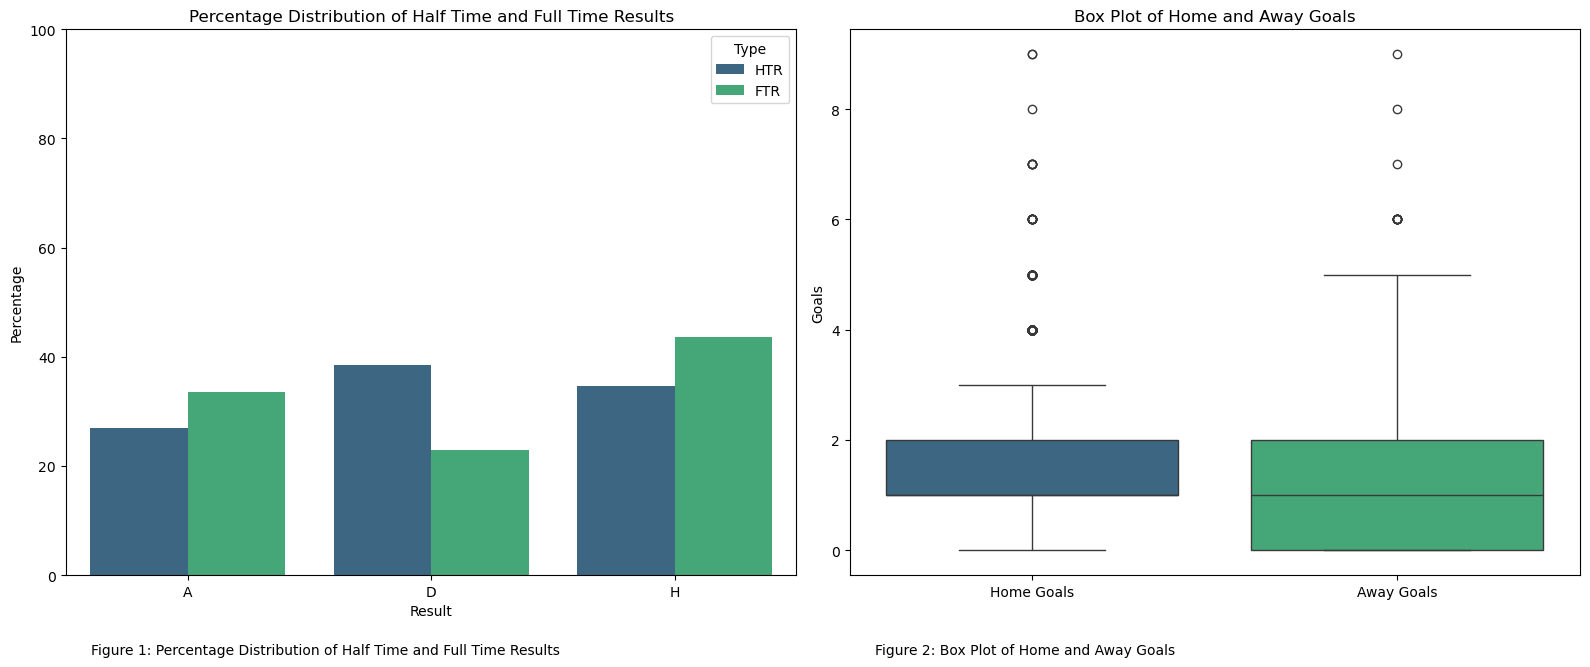

In [26]:
# Create subplots for the first two visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Percentage Distribution of Half Time Result (HTR) and Full Time Result (FTR)
sns.barplot(data=percentage_df_melted, x='Result', y='Percentage', hue='Type', palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Percentage Distribution of Half Time and Full Time Results')
axes[0, 0].set_xlabel('Result')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].set_ylim(0, 100)

# Box plot of Home Goals (FTHG) and Away Goals (FTAG)
sns.boxplot(data=match_results_df[['FTHG', 'FTAG']], palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Home and Away Goals')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Home Goals', 'Away Goals'])
axes[0, 1].set_ylabel('Goals')

# Remove the third and fourth subplots
fig.delaxes(axes[1, 0])
fig.delaxes(axes[1, 1])

# Add annotations for figures
fig.text(0.06, 0.45, 'Figure 1: Percentage Distribution of Half Time and Full Time Results', ha='left', fontsize=10)
fig.text(0.55, 0.45, 'Figure 2: Box Plot of Home and Away Goals', ha='left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

Figure 1 indicates that Half Time Results (`HTR`) tend towards a draw in over 40% of matches. However, the concept of home advantage is evident, as the home team wins more frequently than the away team. This trend is further illustrated by the box plots in Figure 2, which show that the home team scores slightly more goals on average compared to the away team, even though the median goals scored by both teams are the same at 1.

This observation aligns with the findings of Pollard (1986), who extensively studied the phenomenon of home advantage in football.

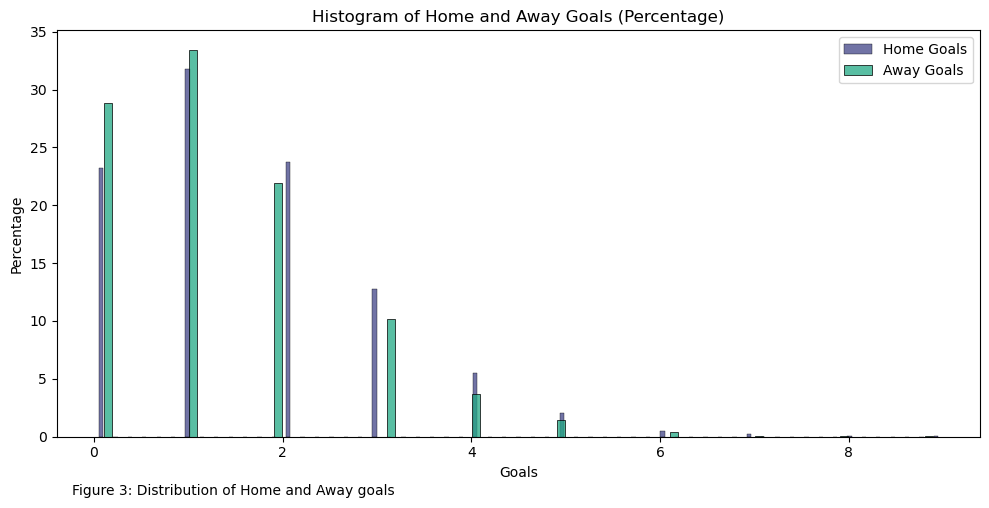

In [28]:
# Create a new figure for the histogram of goals
fig, ax = plt.subplots(figsize=(10,5))

# Histogram of Goals with percentages
sns.histplot(home_goals, stat='percent', color='#414487FF', label='Home Goals', multiple="dodge", shrink=.3, ax=ax)
sns.histplot(away_goals, stat='percent', color='#22A884FF', label='Away Goals', multiple="dodge", shrink=.3, ax=ax)
ax.set_title('Histogram of Home and Away Goals (Percentage)')
ax.set_xlabel('Goals')
ax.set_ylabel('Percentage')
ax.legend()

# Add annotations for figures
fig.text(0.40, 0, 'Figure 3: Distribution of Home and Away goals', ha='right', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Figure 3 strengthens my earlier observations, indicating that the home team tends to score over 2 goals more frequently than the away team. Conversely, the away team often scores 1 goal more frequently than the home team. Noteworthy is that the plot highlights a significant trend: in more than 30% of matches, both teams manage to score at least 1 goal, emerging as the most frequent outcome.

Additionally, the distribution of home and away goals closely aligns with a Poisson distribution, a statistical pattern with implications for potential future analyses. While this characteristic offers insight into match dynamics, exploring its full impact on predicting match outcomes extends beyond the current scope of my research.

For further analysis, I investigated the percentage of home wins and the discrepancy in goals between the home and away teams over years (using the year as a weak proxy for the season). This aimed to uncover discernible patterns or trends associated with home advantage. While Pollard (2005) quantified home advantage as the number of points gained by home teams expressed as a percentage of all points gained, both home and away, in this research, I define home advantage as the yearly percentage of team wins, particularly in the context of the time series analysis conducted. It's important to note that this examination is restricted to the past four seasons. However, for a more comprehensive understanding of the evolution of home advantage over time, expanding the dataset to include additional seasons would be advisable to mitigate any potential for bias or framing.

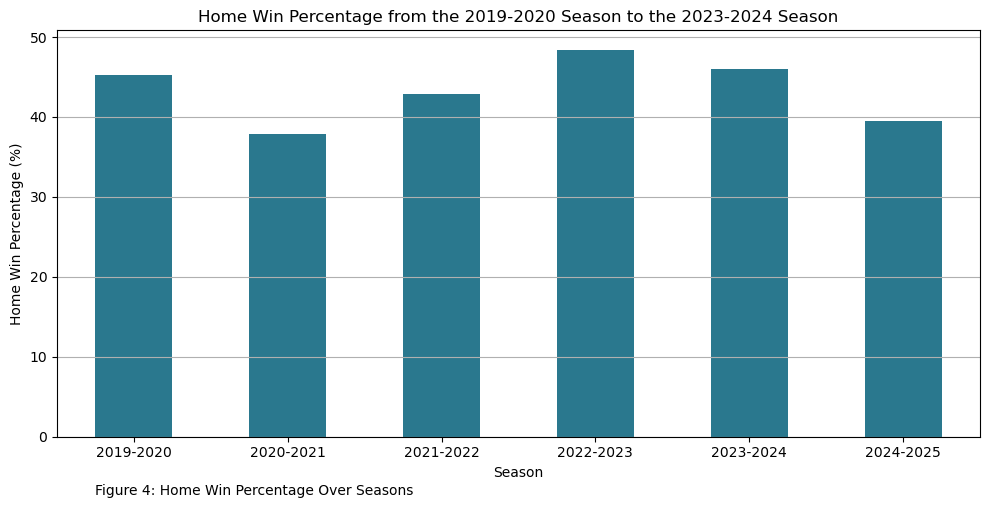

In [30]:
# Calculate Home Win percentage variable for each season
# The lambda function is applied to each group of 'FTR' (Full Time Result) values within each season.
# It counts the occurrences where 'FTR' is 'H' (indicating a home win), then divides it by the total number of matches in that season.
# Finally, it multiplies the result by 100 to convert it into a percentage.
season_win_percentage = premier_league_df.groupby('Season')['FTR'].apply(lambda x: (x == 'H').sum() / len(x) * 100)

# Creating subplots with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting the Win Percentage Over Seasons
season_win_percentage.plot(kind='bar', color='#2A788EFF', ax=ax)
ax.set_title('Home Win Percentage from the 2019-2020 Season to the 2023-2024 Season')
ax.set_xlabel('Season')
ax.set_ylabel('Home Win Percentage (%)')
ax.grid(axis='y')

# Add annotations for figures
fig.text(0.1, 0, 'Figure 4: Home Win Percentage Over Seasons', ha='left', fontsize=10)

# Adjust layout
plt.xticks(rotation=0)  # Rotate x-axis labels
plt.tight_layout()      # Adjust layout to prevent overlap

# Show plot
plt.show()

Figure 4 illustrates the stability of the home win percentage from the 2019-2020 season to the 2023-2024 season, with a noticeable decrease observed in the 2020-2021 season. This drop is possibly attributed to the impact of COVID-19, which led to empty stadiums and other disruptions that affected home advantage (Hamilton, 2021). However, this trend reversed in the 2021-2022 season and continued to increase in the 2022-2023 season, with a slight decrease noted in the 2023-2024 season compared to the preceding season, though still slightly higher than pre-COVID levels. Figure 5 corroborates these findings, depicting a noticeable rise in the average difference between home and away goals. This increase coincides with the easing of COVID restrictions and the return of spectators to stadiums. Notably, while the home team scored fewer goals compared to the away team during the 2020-2021 season, the subsequent seasons show an increase in the average difference in full-time home goals, reverting to pre-COVID levels and even slightly exceeding them.

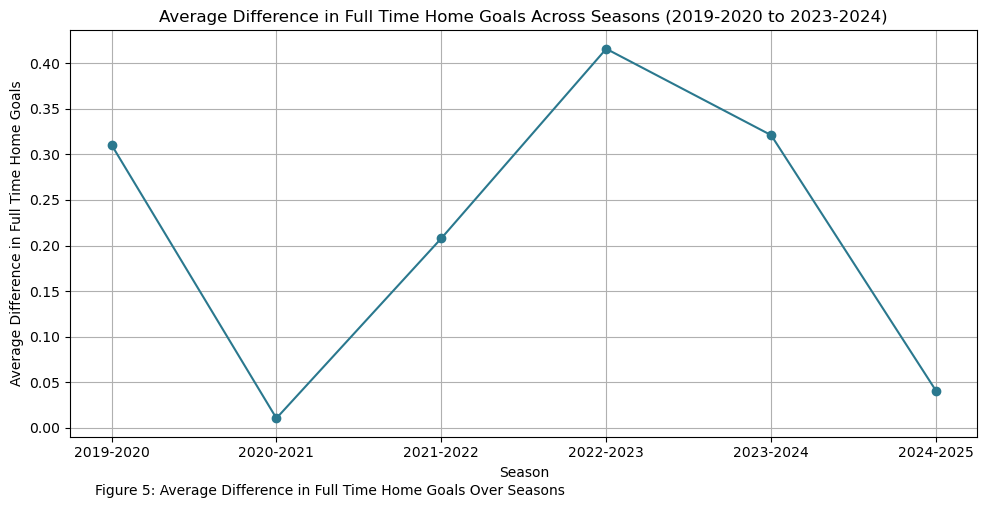

In [32]:
# Aggregating data by season to calculate the average difference in full time home goals
season_avg_fthgdiff = premier_league_df.groupby('Season')['FTHGDIFF'].mean()

# Creating subplots with adjusted figure size
fig, ax = plt.subplots(figsize=(10, 5))  

# Plotting the average difference in full time home goals over seasons
ax.plot(season_avg_fthgdiff.index, season_avg_fthgdiff.values, color='#2A788EFF', marker='o', linestyle='-')
ax.set_title('Average Difference in Full Time Home Goals Across Seasons (2019-2020 to 2023-2024)')
ax.set_xlabel('Season')
ax.set_ylabel('Average Difference in Full Time Home Goals')
ax.grid(True)

# Add annotations for figures
fig.text(0.1, 0, 'Figure 5: Average Difference in Full Time Home Goals Over Seasons', ha='left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

However, it's essential to acknowledge that the specific factors influencing the observed trends during the 2020-2021 season are not examined here but were evidently significant. Future analysis should aim to understand these factors comprehensively to further uncover the underlying dynamics behind home advantage,  as it plays a significant role in shaping match outcomes.

### Match Statistics

Exploring match statistics is crucial for identifying relationships and patterns with match outcomes, as certain statistics may significantly influence the results. To investigate this, I utilized a scatter matrix, employing the `pairplot()` method from the `seaborn` library to visualize the pairwise relationships in the match statistics dataset.

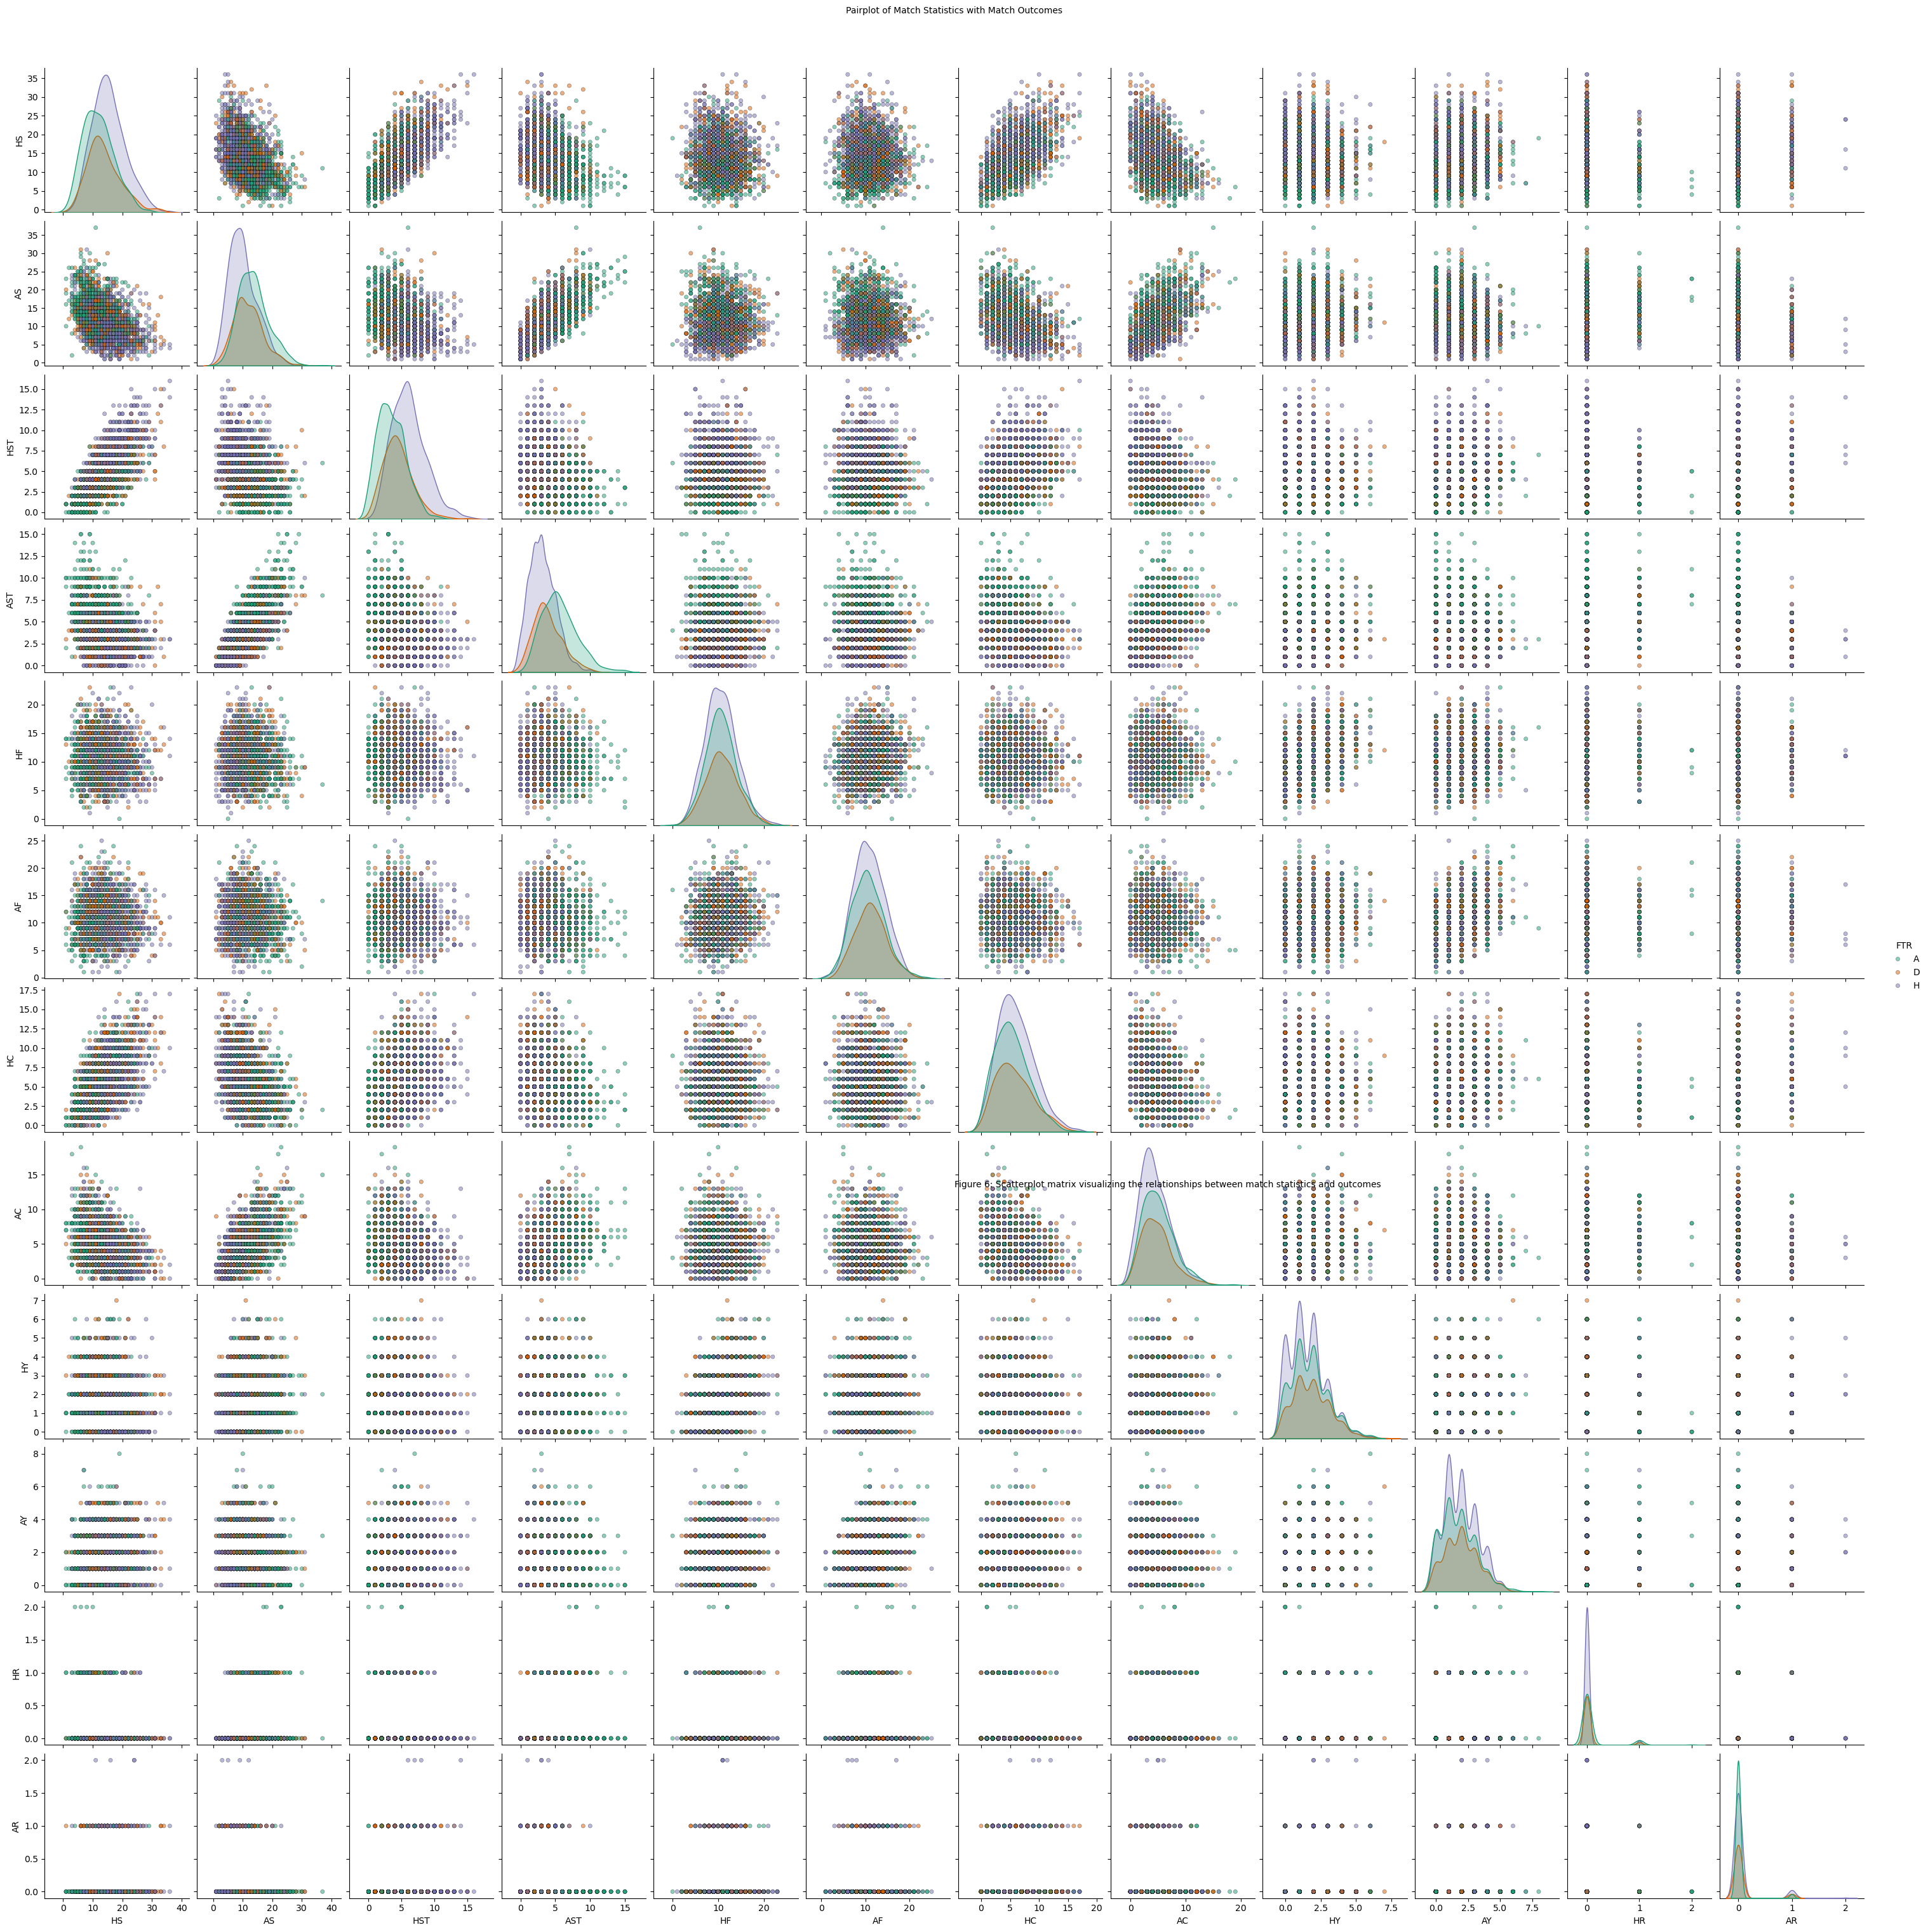

In [35]:
# Adding 'FTR' column to the combined_df to include match outcomes
combined_df = match_stats_df.copy()
combined_df['FTR'] = match_results_df['FTR']

# Create the pairplot with match outcomes colored by 'FTR'
pairplot = sns.pairplot(combined_df, hue='FTR', plot_kws={'alpha': 0.5, 's': 20, 'edgecolor': 'k'}, diag_kind='kde', markers='o', palette='Dark2')

# Adding title and annotation after creating the pairplot
pairplot.fig.suptitle('Pairplot of Match Statistics with Match Outcomes', y=1.02, fontsize=10)
pairplot.fig.text(0.5, 0.4, 'Figure 6: Scatterplot matrix visualizing the relationships between match statistics and outcomes', ha='left', fontsize=10)

# Show the plot
plt.show()

Figure 6 reveals a mix of clear positive and negative relationships, alongside noise. Positively, strong correlations are observed between the number of shots, corners, and shots on target for both home and away teams. This correlation underscores the core objective of football: the winning team usually scores more goals. More shots (including corners) correlate with a higher likelihood of shots on target, subsequently increasing the probability of scoring a goal, thus leading to a favorable match outcome for the team.

Conversely, a negative relationship is observed between the shots of the home team and the away team, indicating the dominance of the team taking more shots. Other variables such as yellow cards, red cards, and fouls show very weak (close to 0) correlations with shooting statistics, as illustrated in Figure 7.

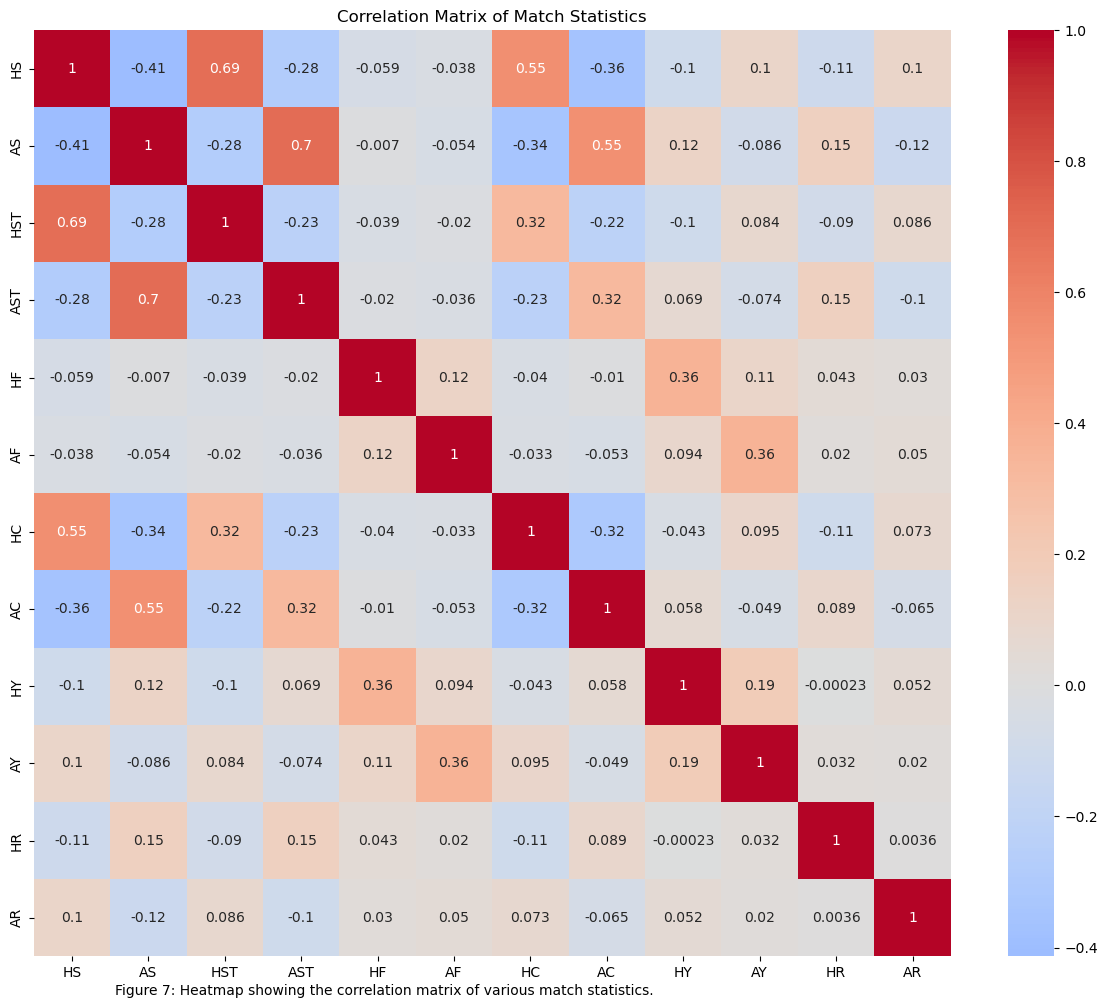

In [37]:
# Create the correlation matrix for match statistics
correlation_matrix = match_stats_df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Match Statistics')

# Adding text annotation for the figure
plt.figtext(0.1, 0, 'Figure 7: Heatmap showing the correlation matrix of various match statistics.', ha='left', fontsize=10)

# Adjust layout to ensure text is displayed correctly
plt.tight_layout()

# Show the plot
plt.show()

Additionally, Figure 7 highlights the limitations of the available match statistics, indicating the need for additional data to gain deeper insights into match outcomes. Missing statistics, such as travel distances, geographical location, team’s Elo rating, and recent performance can also exert significant influence on match outcomes (Settembrea et al., 2024).

Furthermore, in Figure 8 below, I observed the variation in the percentage of shots on target for both the home and away teams over the seasons. This visualization complements our understanding of match statistics by illustrating how efficiently teams convert their shots into on-target opportunities across different seasons.

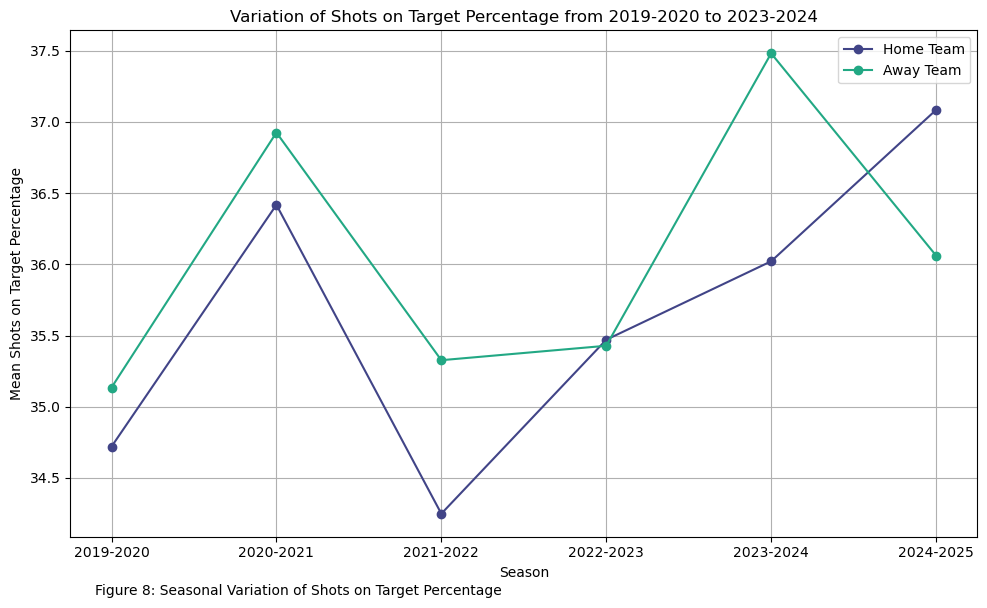

In [39]:
# Create new variables by calculating the percentage of shots on target for home and away teams
premier_league_df['Home_SOT_Percentage'] = (premier_league_df['HST'] / premier_league_df['HS']) * 100
premier_league_df['Away_SOT_Percentage'] = (premier_league_df['AST'] / premier_league_df['AS']) * 100

# Group the data by season and calculate the mean SOT percentage for each group
mean_sot_percentage = premier_league_df.groupby('Season')[['Home_SOT_Percentage', 'Away_SOT_Percentage']].mean()

# Plot the variation of SOT percentage over time
plt.figure(figsize=(10, 6))
plt.plot(mean_sot_percentage.index, mean_sot_percentage['Home_SOT_Percentage'], label='Home Team', marker='o', color='#414487FF')
plt.plot(mean_sot_percentage.index, mean_sot_percentage['Away_SOT_Percentage'], label='Away Team', marker='o', color='#22A884FF')
plt.title('Variation of Shots on Target Percentage from 2019-2020 to 2023-2024')
plt.xlabel('Season')
plt.ylabel('Mean Shots on Target Percentage')
plt.legend()
plt.grid(True)

# Add annotations for figures
plt.figtext(0.1, 0, 'Figure 8: Seasonal Variation of Shots on Target Percentage', ha='left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Figure 8 presents a striking pattern: the away team consistently surpasses the home team in terms of the percentage of shots on target across multiple seasons. This discovery adds a captivating dimension to our comprehension, especially when juxtaposed with the well-established home advantage phenomenon. From the seasons spanning 2019-2020 to 2020-2021, and 2022-2023, the away team consistently demonstrated a greater efficacy in shots on target, with the exception of the 2022-2023 season, where the mean shots on target percentage of the away team was comparable to (though slightly lower than) that of the home team. Nonetheless, there was a noticeable surge in the away team's performance during the 2023-2024 season compared to the preceding one.

This trend echoes the pattern identified in the earlier visualization, which illustrated the average disparity in full-time home goals. Particularly during the seasons 2022-2023 and 2023-2024, there was a rise, signaling a higher percentage of shots on target by both the home team and the away team.

While these findings suggest potential fluctuations in team performance over time, it's crucial to recognize that this consistent superior efficacy of the away team challenges the conventional notion of home advantage. Further exploration is warranted to grasp the seasonal dynamics in the percentage of shots on target, as depicted in the plot below.

However, delving into this aspect exceeds the scope of the present analysis. Let's now pivot our attention towards scrutinizing the betting outcomes.

### Betting Odds

For this analysis, I narrowed down the scope to a subset of the available betting odds data, focusing specifically on the relationship between the betting odds for a home team win and the actual match outcomes. This investigation sheds light on how bookmakers perceive the likelihood of different match outcomes, with a particular emphasis on the home team's performance.

In the subsequent analysis, I presented a visualization illustrating the correlation between betting odds and match outcomes for Premier League matches. This visualization serves as a window into the sentiment of bookmakers (in this case Bet365) regarding match outcomes. However, for a more comprehensive understanding of the betting trends in the Premier League, it's crucial to consider a broader range of data. This includes other bookmakers' odds, Asian handicap odds, and total goals betting odds, which, although present in the dataset, were not included in this research. Such an approach would provide a more holistic view of the overall market sentiment and consensus.

It's important to note that while betting odds encapsulate various factors like historical data and team performance, they do not directly influence match outcomes. Instead, they reflect perceived probabilities and can provide valuable insights if integrated appropriately.

The focus of this project was not primarily on betting insights. Therefore, I deliberately considered only a subset of betting data to address specific research questions related to match outcomes and bookmakers' perceptions.

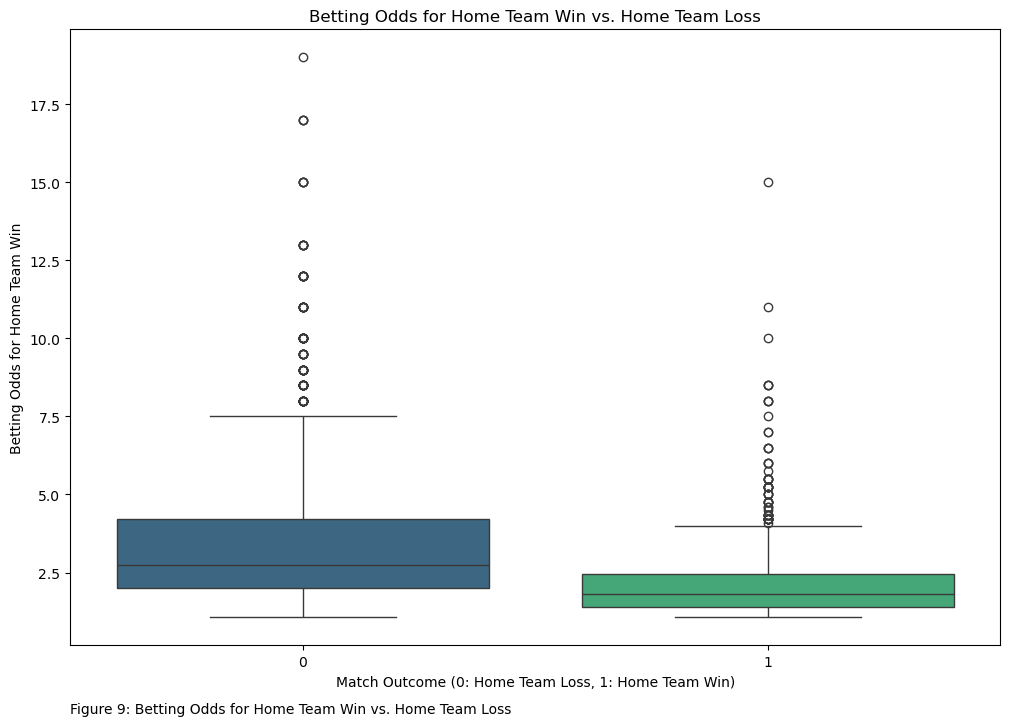

In [42]:
# Create a new binary variable indicating match outcomes where 1 represents a home team win
premier_league_df['HomeTeamWin'] = (premier_league_df['FTR'] == 'H').astype(int)

# Visualize the relationship between betting odds and match outcomes
plt.figure(figsize=(12, 8))
sns.boxplot(data=premier_league_df, x='HomeTeamWin', y='B365H', palette='viridis')

# Set title, labels, and text annotation for the figure
plt.title('Betting Odds for Home Team Win vs. Home Team Loss')
plt.xlabel('Match Outcome (0: Home Team Loss, 1: Home Team Win)')
plt.ylabel('Betting Odds for Home Team Win')
plt.text(-0.5, -2, 'Figure 9: Betting Odds for Home Team Win vs. Home Team Loss', horizontalalignment='left', fontsize=10)

# Show the plot
plt.show()

The box plots in Figure 9 validate the widely-held belief that a home team loss typically corresponds to higher median betting odds compared to a home team win. This trend mirrors the observed patterns in match results, where home teams often secure victories more frequently than away teams, resulting in lower betting odds for a home team win. This pattern is expected to hold true across various bookmakers, especially for matches involving well-known teams like Manchester City, Manchester United, and Liverpool, which are typically perceived as stronger. Conversely, weaker teams are likely to have higher betting odds for a win, reflecting the perceived lower probability of their victory.

However, it's essential to acknowledge that discrepancies in betting odds may arise when teams with similar characteristics compete, prompting bookmakers to adjust odds to reflect subtle differences in their assessments of match outcomes. Without access to data from other bookmakers, it's challenging to confirm or explore these discrepancies further, highlighting a limitation of this analysis. Additionally, examining such discrepancies is beyond the scope of this paper, as the primary focus is to understand the factors influencing Premier League match outcomes.

## Conclusion

Understanding the factors influencing match outcomes is crucial for sports managers, analysts, bettors, bookmakers, and fans alike. This paper aimed to identify the key determinants of match outcomes in the English Premier League using data from football-data.co.uk, covering the seasons from 2019-2020 to 2023-2024.

From the exploratory data analysis, several significant factors emerged:

* **Home Advantage**: Home teams demonstrated a higher winning percentage, reaffirming the well-known phenomenon of home advantage.
* **Number of Goals**: Home teams generally scored more goals than away teams, thereby increasing their likelihood of winning.
* **Match Statistics**: Key match statistics, such as shots, shots on target, and corners, were typically higher for the winning team.

The 2020-2021 season saw a decrease in home advantage, likely due to COVID-19 restrictions, such as empty stadiums. However, once restrictions were eased, the home advantage returned to pre-pandemic levels. Furthermore, the analysis of betting odds supports these findings, showing that bookmakers set higher median odds for teams expected to lose, consistent with observed match outcomes.

Despite these insights, this research represents just the beginning of uncovering the factors influencing match outcomes in the Premier League. While it confirms some existing literature, the dataset used is limited in terms of features. Future research should explore additional datasets, such as those proposed by Bunker, Yeung and Fujii (2024), to gain a more comprehensive understanding of the determinants of match outcomes.

### References

1. Buchheit, M., Settembre, M., Hader, K., Tarascon, A., McHugh, D. & Verheijen, R. (2023a). Know-your-own-League context: Insights for player preparation and recruitment – Part 1: Team formations, Sport Perf & Science Reports, 181, v1.
2. Buchheit, M., Settembre, M., Hader, K., Tarascon, A., McHugh, D. & Verheijen, R. (2023c). Know-your-own-League context: Insights for player preparation and recruitment – Part 3: Players substitutions. Sport Performance & Science Reports, 185, v1.
3. Bunker, R., Yeung, C. & Fujii, K., 2024. Machine learning for soccer match result prediction.
4. Eliakim, E., Morgulev, E., Lidor, R. & Meckel, Y. (2020). Estimation of injury costs: Financial damage of English Premier League teams’ underachievement due to injuries. BMJ Open Sport & Exercise Medicine, 6(1), e000675.
5. football-data.co.uk (2024). England Data Files. [online] Available at: https://www.football-data.co.uk/englandm.php [Accessed 9 June 2024].
6. González-Rodenas, J., Aranda-Malavés, R., Tudela-Desantes, A., Calabuig Moreno, F., Casal, C.A. & Aranda, R. (2019). Effect of Match Location, Team Ranking, Match Status and Tactical Dimensions on the Offensive Performance in Spanish ‘La Liga’ Soccer Matches. Frontiers in Psychology, 12(10), p.2089.
7. Hägglund, M., Waldén, M., Magnusson, H., Kristenson, K., Bengtsson, H. & Ekstrand, J. (2013). Injuries affect team performance negatively in professional football: An 11-year follow-up of the UEFA Champions League injury study. British Journal of Sports Medicine, 47(12), pp.738-742.
8. Hamilton, T. (2021). Premier League's home edge has gone in pandemic era: The impact of fan-less games in England and Europe. ESPN. Retrieved from https://www.espn.co.uk/football/story/_/id/37613907/impact-fan-less-games-england-europe.
9. Harris, C.R., Millman, K.J., van der Walt, S.J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N.J., Kern, R., Picus, M., Hoyer, S., van Kerkwijk, M.H., Brett, M., Haldane, A., del Río, J.F., Wiebe, M., Peterson, P., Gérard-Marchant, P., Sheppard, K., Reddy, T., Weckesser, W., Abbasi, H., Gohlke, C., & Oliphant, T.E. (2020). Array programming with NumPy. Nature, 585(7825), 357-362. [Online]. Available: https://doi.org/10.1038/s41586-020-2649-2.
10. Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. [Online]. Available: https://doi.org/10.1109/MCSE.2007.55.
10. Lago-Peñas, C., Gómez-Ruano, M., Megías-Navarro, D. & Pollard, R. (2016). Home advantage in football: Examining the effect of scoring first on match outcome in the five major European leagues. International Journal of Performance Analysis in Sport, 16, pp.411-421.
11. Myerson Solicitors (2023). Game Changer: How Tech is Changing the Game of Football. Myerson Solicitors. Published 8 December. Available at: https://www.myerson.co.uk/news-insights-and-events/tech-changing-football [Accessed 9 June 2024].
12. Pollard, R. (1986). Home advantage in soccer: a retrospective analysis. J Sports Sci, 4(3), 237 – 248.
13. Pollard, R., & Pollard, G. M. (2005). Home advantage in soccer: a review of its existence and causes. [Online]. Available: https://api.semanticscholar.org/CorpusID:131409487.
14. Radzimiński, Ł., Padrón-Cabo, A., Modric, T., Andrzejewski, M., Versic, S., Chmura, P., Sekulic, D. & Konefał, M. (2022). The effect of mid-season coach turnover on running match performance and match outcome in professional soccer players. Scientific Reports, 12(1), p.10680.
15. Richardson, L., 2007. Beautiful Soup documentation. April.
16. Settembrea, M., Buchheit, M., Hader, K., Hamill, R., Tarascon, A., Verheijen, R., & McHugh, D. (2024). Factors associated with match outcomes in elite European football – insights from machine learning models. Kitman Labs, Dublin, Ireland; Lille OSC, Lille, France; HIITscience, Revelstoke, Canada; INSEP, Paris, France; Type 3.2 Performance, Montvalezan, France; Football Coach Evolution, The Netherlands.
17. The pandas development team (2020) pandas-dev/pandas: Pandas. Version latest. Zenodo. Available at: https://doi.org/10.5281/zenodo.3509134 (Accessed: 12 June 2024).
18. Verheijen, R. (2012). Study on recovery days. World Football Academy.
19. Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021.

© 2024 Goldsmiths, University of London. This document is part of an academic coursework project and is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/). You may share this work, but please provide appropriate credit, and do not use it for commercial purposes or create derivative works.